In [1]:
import numpy as np
import uproot3
import pickle

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import Neutrino_functions

from math import *
import scipy as sci

# MACHINE LEARNING IMPORTS
import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
MC_file = './true_data/MC_EXT_flattened.pkl' 
MC_EXT = pd.read_pickle(MC_file)
features = ['_closestNuCosmicDist', 'trk_len_v', 'trk_distance_v', 'topological_score', 'trk_sce_end_z_v', 'trk_sce_end_y_v', 'trk_sce_end_x_v', 'trk_score_v', 'trk_llr_pid_score_v', 'trk_sce_start_z_v', 'trk_sce_start_y_v', 'trk_sce_start_x_v', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z', 'trk_energy_tot']
data_file = './true_data/data_flattened.pkl'

In [3]:
def replace_values(array):
    replacements = {4: 0, 5: 0, 7: 0, 10: 0, 21: 1, 31: 0}
    return [replacements.get(num, num) for num in array]

In [4]:
MC_EXT_BOOST = MC_EXT.copy(deep=True)

for feature in features:
    MC_EXT_BOOST[feature] = MC_EXT_BOOST[feature].astype(float)

trk_energy_tot = MC_EXT_BOOST['trk_energy_tot']
trk_energy_tot_selection = (trk_energy_tot < 2)
MC_EXT_BOOST = MC_EXT_BOOST[trk_energy_tot_selection]
#MC_EXT_BOOST = MC_EXT_BOOST.drop(MC_EXT_BOOST[MC_EXT_BOOST.category == 10].index, inplace = False)
#MC_EXT_BOOST.reset_index(drop=True, inplace=True)
#MC_EXT_BOOST = MC_EXT_BOOST.drop(MC_EXT_BOOST[MC_EXT_BOOST.category == 31].index, inplace = False)
#MC_EXT_BOOST.reset_index(drop=True, inplace=True)
x_boost = MC_EXT_BOOST[features]
y_boost = np.array(MC_EXT_BOOST['category'])

y_boost = replace_values(y_boost)

x_boost_train, x_boost_test, y_boost_train, y_boost_test = train_test_split(x_boost, y_boost, train_size=0.8, random_state=1) # 80/20 training/test split

In [5]:
boosted_model = XGBClassifier(booster="dart", learning_rate=0.1)
boosted_model.fit(x_boost_train,y_boost_train)

y_boost_pred = boosted_model.predict(x_boost_train)
print("Accuracy on training dataset:",metrics.accuracy_score(y_boost_train, y_boost_pred))
rf_acc_train = metrics.accuracy_score(y_boost_train, y_boost_pred)
y_boost_pred = boosted_model.predict(x_boost_test, iteration_range=(0, 100))
print("Accuracy on testing dataset:",metrics.accuracy_score(y_boost_test, y_boost_pred))
rf_acc_test = metrics.accuracy_score(y_boost_test, y_boost_pred)

Accuracy on training dataset: 0.844124887317107
Accuracy on testing dataset: 0.8263356793676109


In [17]:
def boosted_selections(frame,y_pred):

    total_events = len(frame.index)
    muon_total_events = len(frame[frame['category']==21].index)

    frame = frame.iloc[np.where(y_pred==1)]
    final_events = len(frame.index)
    muon_final_events = len(frame[frame['category']==21].index)

    events = [total_events, final_events]
    muon_events = [muon_total_events, muon_final_events]

    return frame, events, muon_events

In [7]:
ypred = boosted_model.predict(x_boost)

print(len(np.where(ypred==1)))

1


In [8]:
boosted_selections = boosted_selections(MC_EXT_BOOST, ypred)

events = np.array(boosted_selections[1])
print(events)
muon_events = np.array(boosted_selections[2])
efficiency = events/events[0]
purity = muon_events/events
print(efficiency)
print(purity)

MC_EXT_XGB_CUTS = boosted_selections[0]

[144211 114030]
[1.         0.79071638]
[0.72869615 0.85996668]


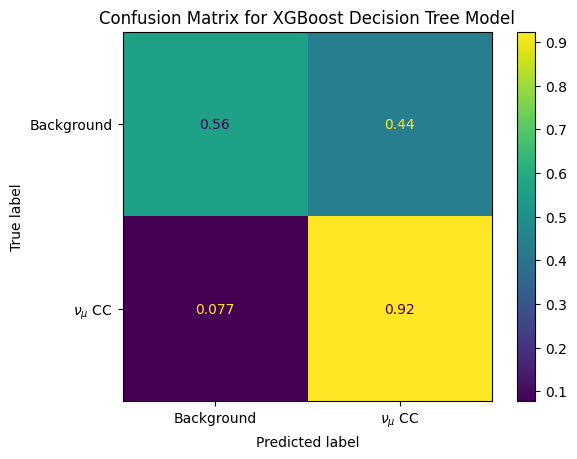

In [14]:
# For labelling your confusion matrix
ptype = [r"Background", r"$\nu$$_\mu$ CC"]

# plot your confusion matrix
cmxgb = confusion_matrix( y_boost_test, y_boost_pred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cmxgb, display_labels=ptype)
disp.plot()
plt.title("Confusion Matrix for XGBoost Decision Tree Model")
plt.show()

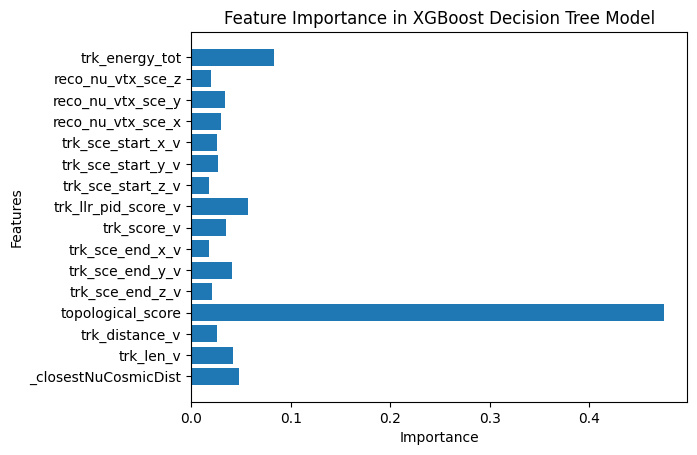

In [15]:
# Plot importance
importance_xgb = boosted_model.feature_importances_

plt.barh(range(16), importance_xgb)
plt.yticks(range(16), features)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance in XGBoost Decision Tree Model")
plt.show()

In [18]:
data = pd.read_pickle(data_file)
data = data.drop('Subevent', axis = 1)

for feature in features:
    data[feature] = data[feature].astype(float)

trk_energy_tot = data['trk_energy_tot']
trk_energy_tot_selection = (trk_energy_tot < 2)
data = data[trk_energy_tot_selection]

data_x_boost = data[features]
data_ypred = np.array(boosted_model.predict(data_x_boost))
boosted_data_frame = boosted_selections(data, data_ypred)[0]

print(len(data),len(boosted_data_frame))

28808 22001


In [19]:
def poisson_error(x):
    return np.sqrt(np.mean(x))/np.mean(x)

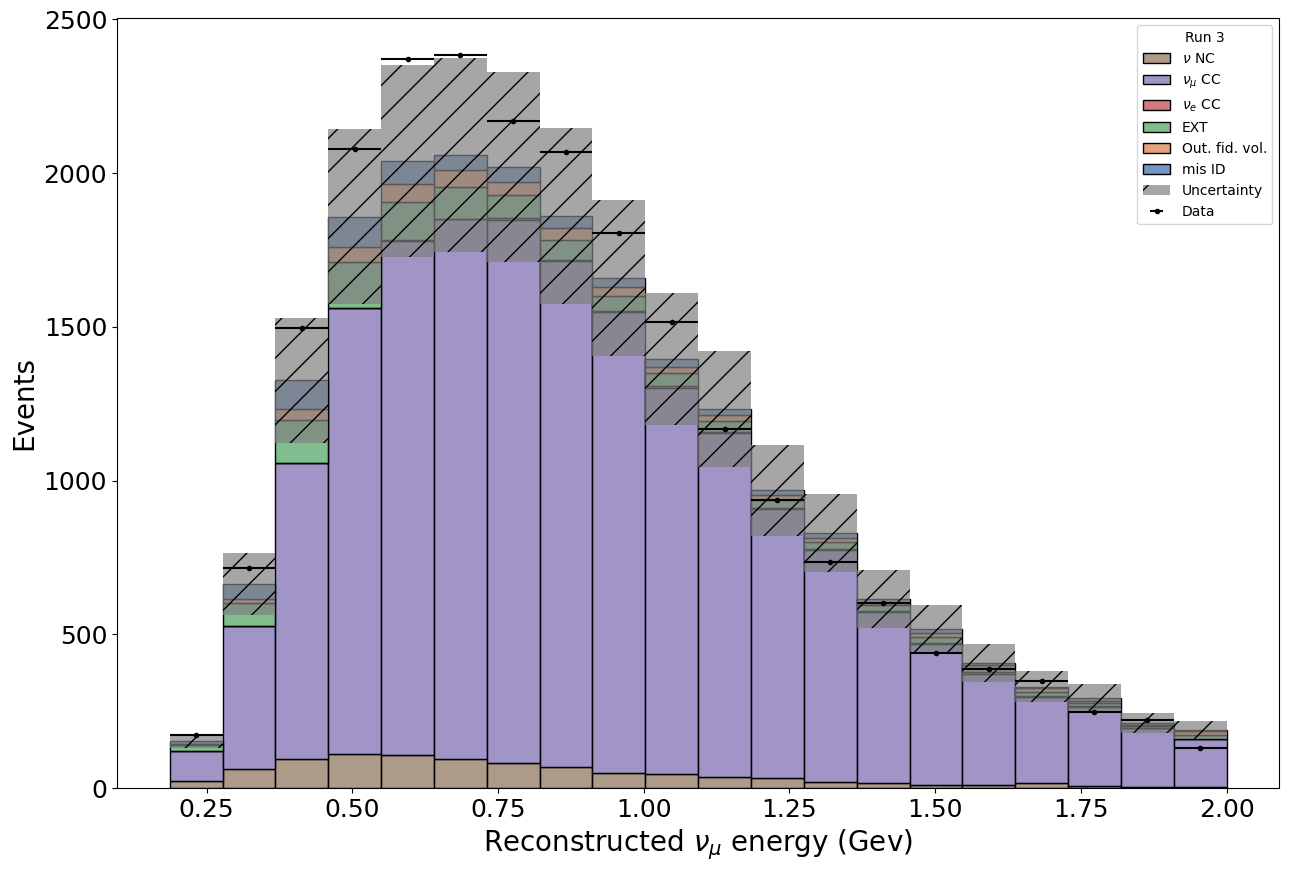

In [20]:
energy_hist_boosted = Neutrino_functions.histogram_plot(MC_EXT_XGB_CUTS, 'trk_energy_tot', 20, 'saved_figure_name', MC_EXT_XGB_CUTS['weight'],xlims=[np.min(MC_EXT_XGB_CUTS['trk_energy_tot']), np.max(MC_EXT_XGB_CUTS['trk_energy_tot'])], plot_data = True, logscale = False, dataFrame = boosted_data_frame, Stat_func=poisson_error)

In [24]:
oscillated_data_file = './true_data/oscillated_data.pkl'
oscillated_data = pd.read_pickle(oscillated_data_file)

for feature in features:
    oscillated_data[feature] = oscillated_data[feature].astype(float)

trk_energy_tot = oscillated_data['trk_energy_tot']
trk_energy_tot_selection = (trk_energy_tot < 2)
oscillated_data = oscillated_data[trk_energy_tot_selection]

oscillated_data_x_boost = oscillated_data[features]
oscillated_data_ypred = boosted_model.predict(oscillated_data_x_boost)
boosted_oscillated_data_frame = boosted_selections(oscillated_data, oscillated_data_ypred)[0]

print(len(oscillated_data),len(boosted_oscillated_data_frame))

144211 114030


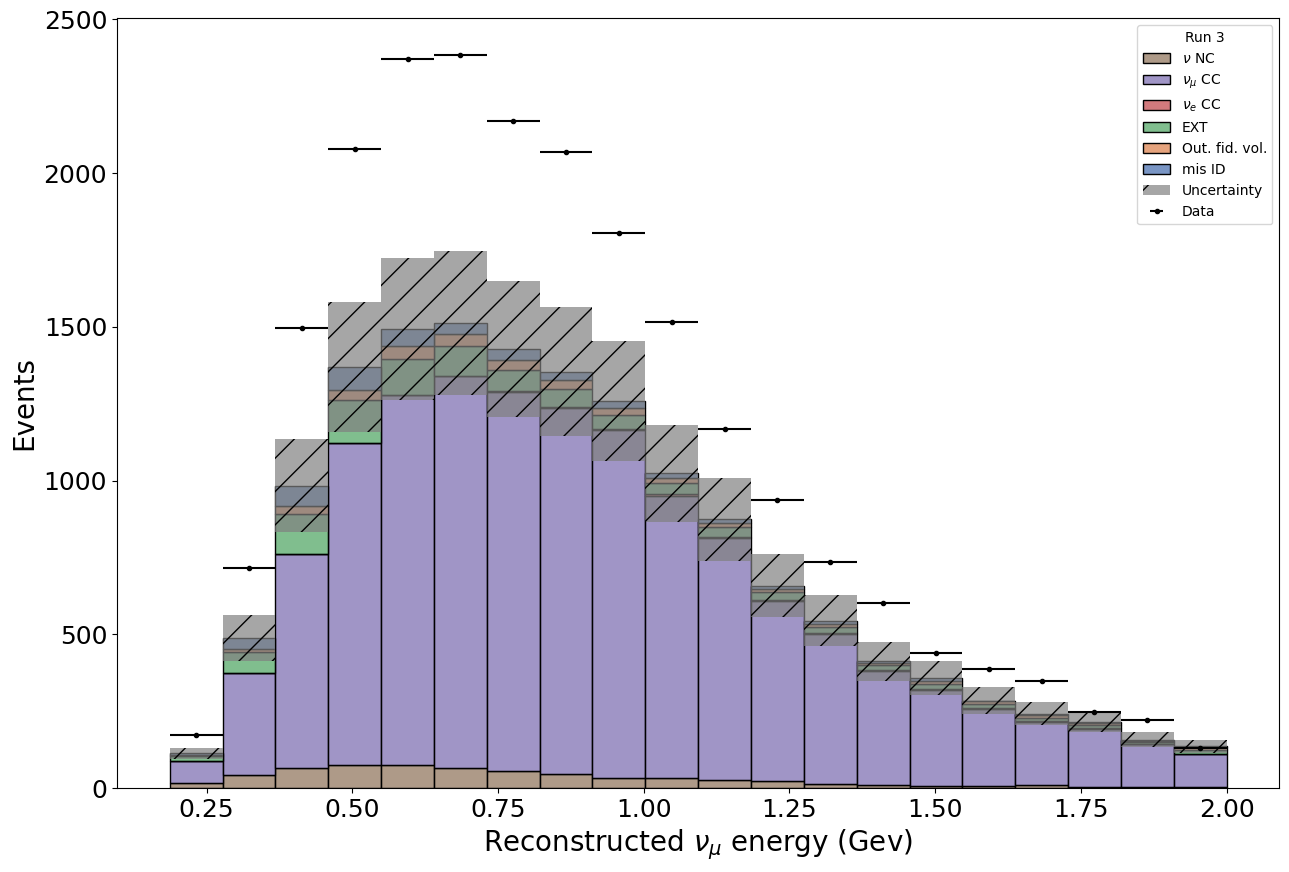

In [25]:
boosted_oscillated_hist = Neutrino_functions.histogram_plot(boosted_oscillated_data_frame, 'trk_energy_tot', 20, 'saved_figure_name', boosted_oscillated_data_frame['weight'],xlims=[np.min(boosted_oscillated_data_frame['trk_energy_tot']), np.max(boosted_oscillated_data_frame['trk_energy_tot'])], plot_data = True, logscale = False, dataFrame = boosted_data_frame, Stat_func=poisson_error)

In [26]:
def oscillation_probability(theta, delta, L, E):
    return theta * (np.sin((1.27*delta*L)/E))**2

def chi_squared(mu,M,sigma):
    return np.sum((mu-M)**2 / sigma**2)

In [39]:
def oscillate_and_chi_xgb(delta,theta,L,E,oscillated_data):
    disappearance = 1 - oscillation_probability(theta,delta,L,E)
    disappearance_hist = np.histogram(MC_EXT_XGB_CUTS['trk_energy_tot'], bins=30, density=False, weights=disappearance*MC_EXT_XGB_CUTS['weight'])
    
    oscillation_hist = np.histogram(oscillated_data['trk_energy_tot'], bins=30, density=False, weights=oscillated_data['weight'])

    # UNC is the uncertainty of the histogram bins. 15% Uncertinanty
    UNC = 0.15*np.array(disappearance_hist[0])

    return chi_squared(disappearance_hist[0],oscillation_hist[0],UNC)

# Function that loops the above function across range of values of delM21 and sin^2(2theta)
def mesh_xgb(deltamin, deltamax, thetamin, thetamax, L,E,oscillated_data):
    delta_values = np.linspace(deltamin,deltamax,100)
    theta_values = np.linspace(thetamin,thetamax,100)
    chi_values = np.zeros((100,100))
    for delta in range(100):
        for theta in range(100):
            #print(oscillate_and_chi(delta_values[delta],theta_values[theta],L,E))
            chi_values[theta,delta] = oscillate_and_chi_xgb(delta_values[delta],theta_values[theta],L,E,oscillated_data)

    return chi_values

def contour_plot_xgb(deltamin, deltamax, thetamin, thetamax, chi_values):
    plt.figure(figsize=(8, 6))
    #ax2.set_title(r'A contour plot of $\chi^2$ values for varying $\lambda_{79Rb}$ and $\lambda_{79Sr}$')
    plt.xlabel(r'sin$^2 2\theta$')
    plt.ylabel(r'$\Delta$m$_{21}^2$')

    min_chi = np.min(chi_values)
    levels1 = np.linspace(0,10,20) + min_chi
    levels2 = [min_chi+2.300, min_chi+4.605, min_chi+5.991, min_chi+9.210]
    
    XMESH, YMESH = np.meshgrid(np.linspace(thetamin,thetamax,100), np.linspace(deltamin,deltamax,100), copy=True, sparse=False, indexing='ij')
    contour_plot = plt.contourf(XMESH, YMESH, chi_values, levels1, cmap='jet')
    plt.colorbar()
    confidence_lines = plt.contour(XMESH, YMESH, chi_values, levels2)
    plt.clabel(confidence_lines, confidence_lines.levels[:1], fmt=r'$\chi^2_{min}$ + 2.300')
    plt.clabel(confidence_lines, confidence_lines.levels[1:2], fmt=r'$\chi^2_{min}$ + 4.605')
    plt.clabel(confidence_lines, confidence_lines.levels[2:3], fmt=r'$\chi^2_{min}$ + 5.991')
    plt.clabel(confidence_lines, confidence_lines.levels[3:4], fmt=r'$\chi^2_{min}$ + 9.210')
    #plt.xscale('log')
    #plt.yscale('log')

    minx, miny = np.where(chi_values == np.min(chi_values))
    print(np.linspace(thetamin,thetamax,100)[minx], np.linspace(deltamin,deltamax,100)[miny])
    #plt.plot(np.linspace(thetamin,thetamax,100)[minx], np.linspace(deltamin,deltamax,100)[miny], 'ro')
    plt.plot(0.55555556,11.12626263, 'ro')
    plt.title("Closure Test for ML Cuts")
    
    plt.show()

[0.55454545] [11.12626263]


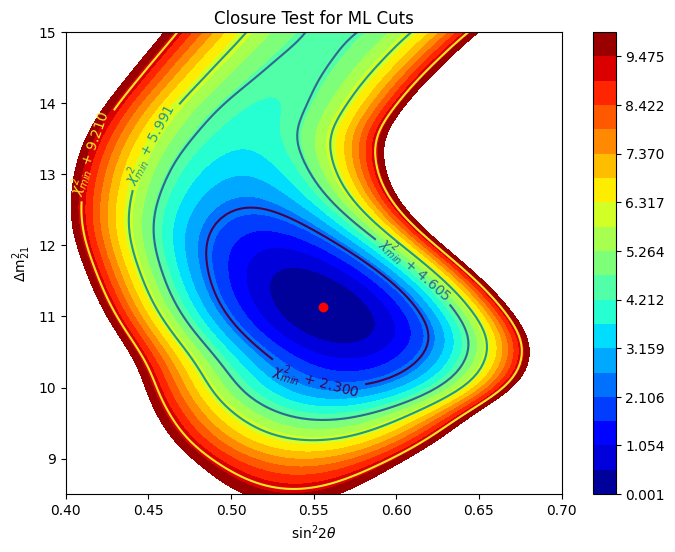

In [40]:
deltamin = 8.5
deltamax = 15
thetamin = 0.4
thetamax = 0.7

#del chi_values

#0.47km is length of neutrino travel

chi_values_xgb = mesh_xgb(deltamin, deltamax, thetamin, thetamax, 0.47, MC_EXT_XGB_CUTS['true_E'], boosted_oscillated_data_frame)
#print(chi_values)

#recommended values to use 10, 15, 0.5, 0.6

contour_plot_xgb(deltamin, deltamax, thetamin, thetamax, chi_values_xgb)

In [42]:
def mesh_data_xgb(deltamin, deltamax, thetamin, thetamax, L,E,oscillated_data):
    delta_values = np.linspace(deltamin,deltamax,50)
    theta_values = np.linspace(thetamin,thetamax,50)
    chi_values = np.zeros((50,50))
    for delta in range(50):
        for theta in range(50):
            #print(oscillate_and_chi(delta_values[delta],theta_values[theta],L,E))
            chi_values[theta,delta] = oscillate_and_chi_data_xgb(delta_values[delta],theta_values[theta],L,E,oscillated_data)

    return chi_values

def oscillate_and_chi_data_xgb(delta,theta,L,E,oscillated_data):
    disappearance = 1 - oscillation_probability(theta,delta,L,E)
    #print(oscillation_probability(delta,theta,L,E))
    disappearance_hist = np.histogram(MC_EXT_XGB_CUTS['trk_energy_tot'], bins=30, density=False, weights=disappearance*MC_EXT_XGB_CUTS['weight'])
    
    oscillation_hist = np.histogram(oscillated_data['trk_energy_tot'], bins=30, density=False)

    # UNC is the uncertainty of the histogram bins. 15% Uncertinanty
    UNC = 0.15*np.array(disappearance_hist[0])
    #np.sqrt((0.15**2)+(poisson_error(disappearance_hist[0])**2))*np.array(disappearance_hist[0])
    #print(disappearance_hist[0])
    #print(oscillation_hist[0])

    return chi_squared(disappearance_hist[0],oscillation_hist[0],UNC)

def contour_plot_data_xgb(deltamin, deltamax, thetamin, thetamax, chi_values):
    plt.figure(figsize=(8, 6))
    #ax2.set_title(r'A contour plot of $\chi^2$ values for varying $\lambda_{79Rb}$ and $\lambda_{79Sr}$')
    plt.xlabel('sin^2 2theta')
    plt.ylabel('delta')

    min_chi = np.min(chi_values)
    #levels1 = np.linspace(0,5,20) + min_chi
    levels2 = [min_chi+4.605, min_chi+5.991, min_chi+9.210]
    
    XMESH, YMESH = np.meshgrid(np.linspace(thetamin,thetamax,50), np.linspace(deltamin,deltamax,50), copy=True, sparse=False, indexing='ij')
    contour_plot = plt.contourf(XMESH, YMESH, chi_values, levels=20, cmap='jet')
    plt.colorbar()
    confidence_lines = plt.contour(XMESH, YMESH, chi_values, levels2)
    plt.clabel(confidence_lines, confidence_lines.levels[:1], fmt=r'$\chi^2_{min}$ + 1')
    plt.clabel(confidence_lines, confidence_lines.levels[1:2], fmt=r'$\chi^2_{min}$ + 2.3')
    plt.clabel(confidence_lines, confidence_lines.levels[2:3], fmt=r'$\chi^2_{min}$ + 5.99')
    plt.xscale('log')
    plt.yscale('log')

    minx, miny = np.where(chi_values == np.min(chi_values))
    print(np.linspace(thetamin,thetamax,50)[minx], np.linspace(deltamin,deltamax,50)[miny])
    plt.plot(np.linspace(thetamin,thetamax,50)[minx], np.linspace(deltamin,deltamax,50)[miny], 'ro')

    plt.show()

[0.001] [0.01]


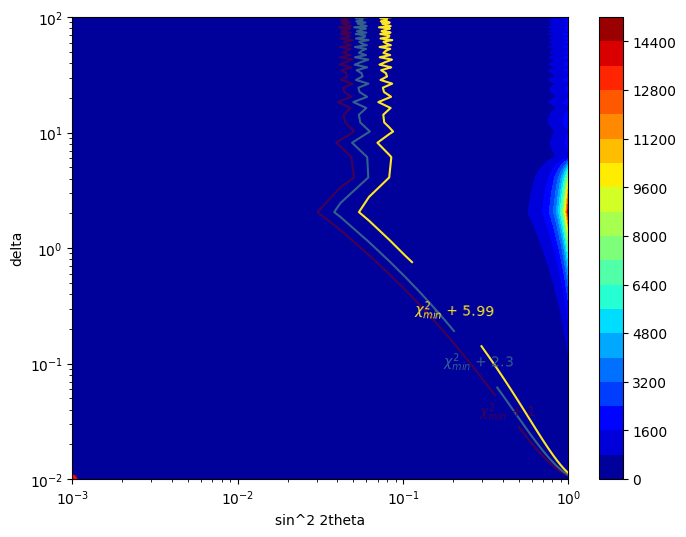

In [43]:
deltamin = 0.01
deltamax = 100
thetamin = 0.001
thetamax = 1

#del chi_values

#0.47km is length of neutrino travel

chi_values_data_xgb = mesh_data_xgb(deltamin, deltamax, thetamin, thetamax, 0.47, MC_EXT_XGB_CUTS['true_E'], boosted_data_frame)
#print(chi_values)

#recommended values to use 10, 15, 0.5, 0.6

contour_plot_data_xgb(deltamin, deltamax, thetamin, thetamax, chi_values_data_xgb)

In [44]:
theta_ue = ((5-np.sqrt(19))/5)*(1-np.sqrt(1-np.linspace(thetamin,thetamax,50)))

In [45]:
def contour_plot_mini(deltamin, deltamax, theta_ue, chi_values):
    plt.figure(figsize=(8, 6))
    #ax2.set_title(r'A contour plot of $\chi^2$ values for varying $\lambda_{79Rb}$ and $\lambda_{79Sr}$')
    plt.xlabel('sin^2 2theta_ue')
    plt.ylabel('delta')

    min_chi = np.min(chi_values)
    #levels1 = np.linspace(0,5,20) + min_chi
    levels2 = [min_chi+4.605, min_chi+5.991, min_chi+9.210]
    
    XMESH, YMESH = np.meshgrid(theta_ue, np.linspace(deltamin,deltamax,50), copy=True, sparse=False, indexing='ij')
    contour_plot = plt.contourf(XMESH, YMESH, chi_values, levels=20, cmap='jet')
    plt.colorbar()
    confidence_lines = plt.contour(XMESH, YMESH, chi_values, levels2)
    plt.clabel(confidence_lines, confidence_lines.levels[:1], fmt=r'$\chi^2_{min}$ + 1')
    plt.clabel(confidence_lines, confidence_lines.levels[1:2], fmt=r'$\chi^2_{min}$ + 2.3')
    plt.clabel(confidence_lines, confidence_lines.levels[2:3], fmt=r'$\chi^2_{min}$ + 5.99')
    plt.xscale('log')
    plt.yscale('log')

    minx, miny = np.where(chi_values == np.min(chi_values))
    print(np.linspace(thetamin,thetamax,50)[minx], np.linspace(deltamin,deltamax,50)[miny])
    plt.plot(np.linspace(thetamin,thetamax,50)[minx], np.linspace(deltamin,deltamax,50)[miny], 'ro')

    plt.show()

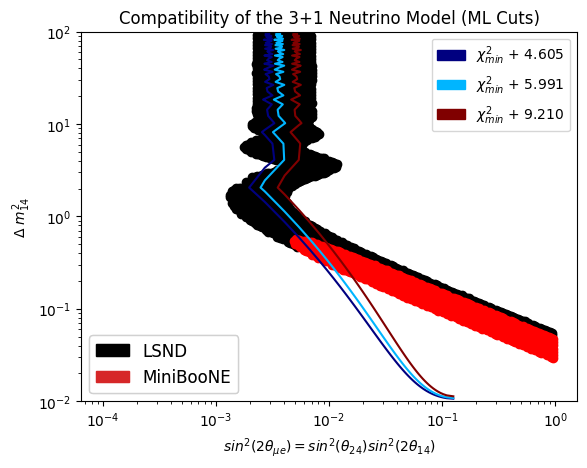

In [46]:
# Load data
LSND_data = pd.read_csv('./true_data/DataSet_LSND.csv').to_numpy()
MiniBooNE_data = pd.read_csv('./true_data/DataSet_MiniBooNE.csv').to_numpy()

# Plot data
plt.plot(LSND_data[:,0],LSND_data[:,1],'ko')
plt.plot(MiniBooNE_data[:,0],MiniBooNE_data[:,1],'ro')

min_chi = np.min(chi_values_data_xgb)
#levels1 = np.linspace(0,5,20) + min_chi
levels2 = [min_chi+4.605, min_chi+5.991, min_chi+9.210]
    
XMESH, YMESH = np.meshgrid(theta_ue, np.linspace(deltamin,deltamax,50), copy=True, sparse=False, indexing='ij')
#contour_plot = plt.contourf(XMESH, YMESH, chi_values, levels=20, cmap='jet')
#plt.colorbar()
confidence_lines = plt.contour(XMESH, YMESH, chi_values_data_xgb, levels2, cmap="jet")
#plt.clabel(confidence_lines, confidence_lines.levels[:1], inline=1, fmt=r'$\chi^2_{min}$ + 1')
#plt.clabel(confidence_lines, confidence_lines.levels[1:2], inline=1, fmt=r'$\chi^2_{min}$ + 2.3')
#plt.clabel(confidence_lines, confidence_lines.levels[2:3], inline=1, fmt=r'$\chi^2_{min}$ + 5.99')
#plt.xscale('log')
#plt.yscale('log')

legend_labels = [r'$\chi^2_{min}$ + 4.605', r'$\chi^2_{min}$ + 5.991', r'$\chi^2_{min}$ + 9.210']
legend_handles = []
for i, level in enumerate(levels2):
    legend_handles.append(mpatches.Patch(color=confidence_lines.collections[i].get_edgecolor(), label=legend_labels[i]))
legend = plt.legend(handles=legend_handles, loc='upper right')

minx, miny = np.where(chi_values_data_xgb == np.min(chi_values_data_xgb))
#print(np.linspace(thetamin,thetamax,50)[minx], np.linspace(deltamin,deltamax,50)[miny])
#plt.plot(np.linspace(thetamin,thetamax,50)[minx], np.linspace(deltamin,deltamax,50)[miny], 'ro')

# Producing MiniBooNE/LSND legend
LSND_path = mpatches.Patch(color='black', label = 'LSND')
MINI_path = mpatches.Patch(color='tab:red', label = 'MiniBooNE')
first_legend = plt.legend(handles=[LSND_path, MINI_path], loc = 'lower left', fontsize = 12)
plt.gca().add_artist(first_legend)
plt.gca().add_artist(legend)

plt.title("Compatibility of the 3+1 Neutrino Model (ML Cuts)")
plt.xlabel(r'$sin^2(2\theta_{\mu e})=sin^2(\theta_{24})sin^2(2\theta_{14})$')
plt.ylabel(r'$\Delta$ $m_{14}^2$')
plt.xticks()
plt.yticks()
plt.yscale('log')
plt.xscale('log')
plt.show()